In [290]:
# Robert Cocker
# Dr. Farin
# DATA 3402
# Lab 6
# 3/16/2024

# Lab 6

You are tasked with evaluating card counting strategies for black jack. In order to do so, you will use object oriented programming to create a playable casino style black jack game where a computer dealer plays against $n$ computer players and possibily one human player. If you don't know the rules of blackjack or card counting, please google it. 

A few requirements:
* The game should utilize multiple 52-card decks. Typically the game is played with 6 decks.
* Players should have chips.
* Dealer's actions are predefined by rules of the game (typically hit on 16). 
* The players should be aware of all shown cards so that they can count cards.
* Each player could have a different strategy.
* The system should allow you to play large numbers of games, study the outcomes, and compare average winnings per hand rate for different strategies.

1. Begin by creating a classes to represent cards and decks. The deck should support more than one 52-card set. The deck should allow you to shuffle and draw cards. Include a "plastic" card, placed randomly in the deck. Later, when the plastic card is dealt, shuffle the cards before the next deal.

In [303]:
import random
import numpy as np
import matplotlib.pyplot as plt

class Card:
    def __init__(self, suit, rank):
        self.suit = suit
        self.rank = rank

    def __str__(self):
        return f"{self.rank} of {self.suit}"

class Deck:
    def __init__(self, num_decks=1):
        self.num_decks = num_decks
        self.cards = [Card(suit, rank) for _ in range(num_decks) for suit in ['Clubs', 'Hearts', 'Spades', 'Diamonds'] 
        for rank in ['2', '3', '4', '5', '6', '7', '8', '9', '10', 'Jack', 'Queen', 'King', 'Ace']]
        self.plastic_position = random.randint(0, 52 * num_decks)  # position of plastic card

    def shuffle(self):
        random.shuffle(self.cards)

    def draw(self):
        return self.cards.pop(0)

    def needs_reshuffle(self):
        return self.cards and len(self.cards) == self.plastic_position

class Player:
    def __init__(self, name, chips=0):
        self.name = name
        self.chips = chips
        self.hand = Hand()

    def buy_chips(self):
        self.chips += int(input(f"{self.name}, how many chips would you like to buy? (Maximum bet 10,000 chips) "))

    def receive_card(self, card):
        self.hand.add_card(card)

    def clear_hand(self):
        self.hand.clear()

    def get_hand_value(self):
        return self.hand.get_value()

    def buy_chips(self):
        self.chips += int(input(f"{self.name}, how many chips would you like to buy? "))

    def make_bet(self, amount):
        if amount > self.chips:
            print("Insufficient chips. Please bet a lower amount.")
            return False
        else:
            self.chips -= amount
            return True

class HumanPlayer(Player):
    pass
            
class Hand:
    def __init__(self):
        self.cards = []

    def add_card(self, card):
        self.cards.append(card)

    def get_value(self):
        total_value = 0
        num_aces = 0
        for card in self.cards:
            if card.rank in ['Jack', 'Queen', 'King']:
                total_value += 10
            elif card.rank == 'Ace':
                num_aces += 1
                total_value += 11  # Initial value of Ace is 11
            else:
                total_value += int(card.rank)

        # Adjust Ace value if needed
        while total_value > 21 and num_aces:
            total_value -= 10  # Change Ace value to 1
            num_aces -= 1

        return total_value

    def is_busted(self):
        return self.get_value() > 21
    
    def clear(self):
        self.cards.clear()

class Game:
    def __init__(self, verbose=True):
        self.players = []
        self.dealer = Dealer("Dealer", deck=Deck())
        self.running = True
        self.verbose = verbose

    def select_mode(self):
        mode = input("Choose mode (auto/regular): ").lower()
        return mode
        
    def setup_game(self):
        num_players = int(input("Enter the number of players (up to 7): "))
        if num_players < 1 or num_players > 7:
            raise ValueError("Number of players must be between 1 and 7")
        mode = self.select_mode()
        for i in range(num_players):  
            name = input(f"Enter name for Player {i+1}: ")
            if mode == 'auto' and i != 0:
                self.players.append(CardCountPlayer2(name))
            else:
                player_type = input(f"Enter type for Player {i+1} (human/card_counter): ")
                if player_type == "human":
                    self.players.append(HumanPlayer(name))
                elif player_type == "card_counter":
                    self.players.append(CardCounterPlayer2(name))
                else:
                    raise ValueError("Invalid player type. Choose 'human' or 'card_counter'.")
                    
        # dealer
        self.dealer = Dealer("Dealer", deck=Deck())
        self.players.append(self.dealer)

    def start_round(self):
        self.dealer.deck = Deck()
        self.dealer.deck.shuffle()
        for player in self.players:
            player.clear_hand()
        self.dealer.deal_initial_cards(self.players + [self.dealer])

    def start_game(self):
        print("\nWelcome to the Blackjack Game!\n")
        for player in self.players:
            chips = int(input(f"{player.name}, how many chips would you like to buy? (Maximum bet 10,000 chips) "))
            player.buy_chips(chips)

    def play_round(self):
        print("\nStarting a new round...")
        for player in self.players:
            # Skipping human players in auto mode
            if isinstance(player, HumanPlayer):
                continue
            print(f"\n{player.name}'s turn:")
            if player.chips <= 0:  # Skip if player has no chips
                print(f"{player.name} has no chips and skips this round.")
                continue
            max_bet = min(player.chips, 10000) # max bet 10,000 chips
            print(f"You have {player.chips} chips.")
            bet = int(input(f"Enter your bet amount (maximum bet: {max_bet:,} chips): "))
            while bet > player.chips or bet <= 0:  # Ensure the bet is valid
                print("Invalid bet amount. Please enter a valid bet.")
                bet = int(input(f"Enter your bet amount (maximum bet: {max_bet:,} chips): "))
            if player.make_bet(bet):
                self.dealer.deal_card(player)
                print(f"{player.name}'s hand: {', '.join(str(card) for card in player.hand.cards)}")
                if isinstance(player, CardCounterPlayer):  # Check if player is a CardCounterPlayer
                    for card in player.hand.cards:
                        player.count_card(card)
                    while True:
                        decision = player.make_decision()
                        print(f"{player.name} decides to {decision}.")
                        if decision == 'hit':
                            self.dealer.deal_card(player)
                            print(f"{player.name}'s hand: {', '.join(str(card) for card in player.hand.cards)}")
                            if player.get_hand_value() > 21:
                                print(f"{player.name} busts.")
                                break
                        else:
                            print(f"{player.name} stays.")
                            break
            else:
                print(f"{player.name} cannot make a bet and skips this round.")
                player.clear_hand()
            
        print("\nDealer's turn:")
        self.dealer.deal_card(self.dealer)
        self.dealer.deal_card(self.dealer)
        bet = 1000
        self.end_round(bet) 
        print(f"Dealer's hand: {self.dealer.hand.cards[0]}, [Hidden]")
        return bet
    
    def end_round(self, bet, verbose=False):
        aggregated_output = ""
        for player in self.players:
            if not isinstance(player, Dealer):
                if player.hand.is_busted():
                    print(f"{player.name} busted.")
                elif self.dealer.hand.is_busted() or player.hand.get_value() > self.dealer.hand.get_value():
                    print(f"{player.name} wins {bet} chips.")
                    player.chips += bet
                elif player.hand.get_value() < self.dealer.hand.get_value():
                    print(f"{player.name} loses {bet} chips.")
                    player.chips -= bet
                elif player.hand.get_value() == self.dealer.hand.get_value():
                    print(f"{player.name} ties with the dealer.")
                else:
                    if mode == 'auto':
                        aggregated_output += player.chips
                        if verbose:
                            print(f"Simulation running...")
            
            return aggregated_output
                        

    def play(self):
        print("\nWelcome to Blackjack!\n")
        mode = self.select_mode()
        card_counter_winnings = 0

        if mode == 'auto':
            num_games, num_rounds, initial_chips = self.get_auto_settings()
            self.setup_auto_mode(initial_chips)
            all_winnings = self.play_auto_mode(num_games, num_rounds, initial_chips)
            if self.verbose:
                print("Simulation running...\n")
            self.display_auto_results(all_winnings, num_games, num_rounds)
        elif mode == 'regular':
            self.setup_regular_mode()
            self.play_regular_mode()
        else:
            print("Invalid mode. Please choose either 'auto' or 'regular'.")
        if self.verbose:
            print(f"CardCounterPlayer's total winnings: {card_counter_winnings}")

    def get_auto_settings(self):
        return (
            int(input("Enter number of games: ")),
            int(input("Enter number of rounds: ")),
            int(input("Enter initial amount of chips per player: "))
        )
    
    def setup_auto_mode(self, initial_chips):
        self.players.append(Dealer("Dealer", deck=Deck()))
        for _ in range(4):  # maximum of 7 players including dealer
            self.players.append(CardCounterPlayer(f"Player {len(self.players) + 1}"))
    
    def play_auto_mode(self, num_games, num_rounds, initial_chips):
        all_winnings = []
        dealer_index = None
        
        for i, player in enumerate(self.players):
            if isinstance(player, Dealer):
                dealer_index = i
                break
                
        # Initial chips for players 10,000
        for player in self.players:
            if isinstance(player, Player):
                player.chips = 100000
        
        for _ in range(num_games):
            winnings_per_game = []
            for _ in range(num_rounds):
                self.start_round()
                bet = 100 
                self.end_round(bet)
                card_counter_winnings = sum(player.chips - initial_chips for player in self.players if not isinstance(player, Dealer))
                winnings_per_game.append(card_counter_winnings)
            all_winnings += winnings_per_game
        return all_winnings
    
    def display_auto_results(self, all_winnings, num_games, num_rounds):
        if all_winnings:
            average_winnings_per_round = np.mean(all_winnings) / (num_games * num_rounds)
            std_dev = np.std(all_winnings)
            net_winnings = [w for w in all_winnings if w > 0]
            net_loss = [w for w in all_winnings if w < 0]
            prob_win = len(net_winnings) / len(all_winnings)
            prob_loss = len(net_loss) / len(all_winnings)
            plt.hist(all_winnings, bins=20)
            plt.title('Aggregate Histogram of Winnings')
            plt.xlabel('Winnings')
            plt.ylabel('Frequency')
            plt.show()
            print("Aggregate Statistics:")
            print(f"Average winnings per round: {average_winnings_per_round}")
            print(f"Standard deviation of winnings: {std_dev}")
            print(f"Probability of net winning after {num_rounds} rounds: {prob_win}")
            print(f"Probability of net losing after {num_rounds} rounds: {prob_loss}")
    
    def setup_regular_mode(self):
        num_players = int(input("Enter the number of players (up to 7): "))
        if num_players < 1 or num_players > 7:
            raise ValueError("Number of players must be between 1 and 7")
        for i in range(num_players):
            name = input(f"Enter name for Player {i+1}: ")
            player_type = input(f"Enter type for Player {i+1} (human/card_counter): ")
            if player_type == "human":
                self.players.append(HumanPlayer(name))
            elif player_type == "card_counter":
                self.players.append(CardCounterPlayer(name))
            else:
                raise ValueError("Invalid player type. Choose 'human' or 'card_counter'.")
        for player in self.players:
            if not isinstance(player, Dealer):
                chips = int(input(f"{player.name}, how many chips would you like to buy? (Maximum bet 10,000 chips) "))
                player.buy_chips()
    
    def play_regular_mode(self):
        self.setup_game()
        while self.running:
            self.start_round()
            bet = self.play_round()
            self.end_round(bet)
            self.running = input("Do you want to play another round? (yes/no): ").lower() == 'yes'


class Dealer(Player):
    def __init__(self, name, deck):
        super().__init__(name)
        self.deck = deck
        self.hand = Hand()

    def buy_chips(self):
        pass

    def receive_card(self, card):
        self.hand.add_card(card)

    def clear_hand(self):
        self.hand.clear()

    def get_hand_value(self):
        return self.hand.get_value()

    def deal_card(self, player=None):
        card = self.deck.draw()
        if player:
            player.receive_card(card)
        else:
            self.hand.add_card(card)

    def deal_initial_cards(self, players):
        for _ in range(2):
            for player in players:
                self.deal_card(player)
            self.deal_card()

class CardCounterPlayer(Player):
    def __init__(self, name):
        super().__init__(name)
        self.card_count = 0

    def count_card(self, card):
        if card.rank in ['2', '3', '4', '5', '6']:
            self.card_count += 1
        elif card.rank in ['10', 'Jack', 'Queen', 'King', 'Ace']:
            self.card_count -= 1

    def make_decision(self):
        if self.card_count <= -2:
            return 'hit'
        elif self.card_count >= -0:
            return 'stay'
        else:
            return 'hit' 

import random

class CardCounterPlayer2(Player):
    def __init__(self, name):
        super().__init__(name)
        self.q_table = {}  
        self.epsilon = 0.1  
        self.alpha = 0.8 # Learning rate
        self.gamma = 0.9  
        self.state = None
        self.action_space = ['hit', 'stay']

    def get_state(self, dealer_card):
        return (self.hand.get_value(), dealer_card.rank)

    def get_action(self):
        if random.random() < self.epsilon:
            return random.choice(self.action_space)
        else:
            if self.state in self.q_table:
                return max(self.q_table[self.state], key=self.q_table[self.state].get)
            else:
                return random.choice(self.action_space)

    def update_q_table(self, next_state, reward):
        if self.state not in self.q_table:
            self.q_table[self.state] = {'hit': 0, 'stay': 0}

        if next_state not in self.q_table:
            self.q_table[next_state] = {'hit': 0, 'stay': 0}

        max_next_q = max(self.q_table[next_state].values())
        self.q_table[self.state][self.action] += self.alpha * (reward + self.gamma * max_next_q - self.q_table[self.state][self.action])

    def make_decision(self, dealer_card):
        self.state = self.get_state(dealer_card)
        self.action = self.get_action()
        return self.action


In [4]:
# Test the class
deck = Deck(num_decks=6)  # Create a deck with 6 sets of 52 cards
deck.shuffle()  # Shuffle deck

# Draw a card
card = deck.draw()
print("Drawn card:", card)

# Check deck if needs reshuffling (plastic card)
if deck.needs_reshuffle():
    deck.shuffle()

Drawn card: 10 of Diamonds


2. Now design your game on a UML diagram. You may want to create classes to represent, players, a hand, and/or the game. As you work through the lab, update your UML diagram. At the end of the lab, submit your diagram (as pdf file) along with your notebook. 

In [ ]:
# See UML diagram in Lab.6 folder

3. Begin with implementing the skeleton (ie define data members and methods/functions, but do not code the logic) of the classes in your UML diagram.

In [ ]:
# See cell 1 for class implementations

4. Complete the implementation by coding the logic of all functions. For now, just implement the dealer player and human player.

In [ ]:
# See cell 1 for class implementation. Updated classes as I went along through the steps.

5.  Test. Demonstrate game play. For example, create a game of several dealer players and show that the game is functional through several rounds.

In [49]:
# See cell 1 for logic and class implementations.
# Testing blackjack game
num_players = 2
player_info = [("Player 1", "human"), ("Player 2", "card_counter")]
game = Game(player_info)
game.play()


Starting a new round...

Player 1's turn:


Player 1, how many chips would you like to buy?  20000


You have 20000 chips.


Enter your bet amount (maximum bet: 10,000 chips):  5000


Player 1's hand: 4 of Diamonds, Queen of Spades, 7 of Diamonds, 4 of Spades

Player 2's turn:


Player 2, how many chips would you like to buy?  20000


You have 20000 chips.


Enter your bet amount (maximum bet: 10,000 chips):  5000


Player 2's hand: Queen of Diamonds, 4 of Clubs, 2 of Hearts, King of Clubs

Dealer's turn:
Dealer's hand: King of Hearts, [Hidden]

Round ended. Evaluating hands...
Dealer's hand value: 46
Player 1's hand value: 25
Player 1 loses 5000 chips.
Player 2's hand value: 26
Player 2 loses 5000 chips.


Do you want to play another round? (yes/no):  yes



Starting a new round...

Player 1's turn:


Player 1, how many chips would you like to buy?  50000


You have 60000 chips.


Enter your bet amount (maximum bet: 10,000 chips):  5000


Player 1's hand: Jack of Clubs, 5 of Clubs, Jack of Hearts, 3 of Clubs

Player 2's turn:


Player 2, how many chips would you like to buy?  50000


You have 60000 chips.


Enter your bet amount (maximum bet: 10,000 chips):  5000


Player 2's hand: 3 of Diamonds, Queen of Hearts, King of Spades, 2 of Diamonds

Dealer's turn:
Dealer's hand: 2 of Spades, [Hidden]

Round ended. Evaluating hands...
Dealer's hand value: 44
Player 1's hand value: 28
Player 1 loses 5000 chips.
Player 2's hand value: 25
Player 2 loses 5000 chips.


Do you want to play another round? (yes/no):  no


6. Implement a new player with the following strategy:

    * Assign each card a value: 
        * Cards 2 to 6 are +1 
        * Cards 7 to 9 are 0 
        * Cards 10 through Ace are -1
    * Compute the sum of the values for all cards seen so far.
    * Hit if sum is very negative, stay if sum is very positive. Select a threshold for hit/stay, e.g. 0 or -2.  

In [57]:
# See cell 1 CardCounterPlayer class
# Testing blackjack game
num_players = 2
player_info = [("Player 1", "human"), ("Player 2", "card_counter")]
game = Game(player_info)
game.play()


Starting a new round...

Player 1's turn:


Player 1, how many chips would you like to buy?  50000


You have 50000 chips.


Enter your bet amount (maximum bet: 10,000 chips):  500


Player 1's hand: Queen of Diamonds, King of Spades, 5 of Spades, 2 of Clubs

Player 2's turn:


Player 2, how many chips would you like to buy?  50000


You have 50000 chips.


Enter your bet amount (maximum bet: 10,000 chips):  500


Player 2's hand: 9 of Spades, 3 of Diamonds, Queen of Hearts, 9 of Hearts
Player 2 decides to hit.
Player 2's hand: 9 of Spades, 3 of Diamonds, Queen of Hearts, 9 of Hearts, Jack of Spades
Player 2 busts.

Dealer's turn:
Dealer's hand: King of Clubs, [Hidden]

Round ended. Evaluating hands...
Dealer's hand value: 33
Player 1's hand value: 27
Player 1 loses 500 chips.
Player 2's hand value: 41
Player 2 loses 500 chips.


Do you want to play another round? (yes/no):  no


7. Create a test scenario where one player, using the above strategy, is playing with a dealer and 3 other players that follow the dealer's strategy. Each player starts with same number of chips. Play 50 rounds (or until the strategy player is out of money). Compute the strategy player's winnings. You may remove unnecessary printouts from your code (perhaps implement a verbose/quiet mode) to reduce the output.


Welcome to Blackjack!



Choose mode (auto/regular):  auto
Enter number of games:  1
Enter number of rounds:  50
Enter initial amount of chips per player:  2000


Simulation running...
Player 2 wins 10000 chips.
Player 3 wins 10000 chips.
Player 4 wins 10000 chips.
Player 5 wins 10000 chips.
Player 2 wins 10000 chips.
Player 3 wins 10000 chips.
Player 4 wins 10000 chips.
Player 5 wins 10000 chips.
Player 2 wins 10000 chips.
Player 3 wins 10000 chips.
Player 4 wins 10000 chips.
Player 5 wins 10000 chips.
Player 2 wins 10000 chips.
Player 3 wins 10000 chips.
Player 4 wins 10000 chips.
Player 5 wins 10000 chips.
Player 2 wins 10000 chips.
Player 3 wins 10000 chips.
Player 4 wins 10000 chips.
Player 5 wins 10000 chips.
Player 2 wins 10000 chips.
Player 3 wins 10000 chips.
Player 4 wins 10000 chips.
Player 5 wins 10000 chips.
Player 2 wins 10000 chips.
Player 3 wins 10000 chips.
Player 4 wins 10000 chips.
Player 5 wins 10000 chips.
Player 2 wins 10000 chips.
Player 3 wins 10000 chips.
Player 4 wins 10000 chips.
Player 5 wins 10000 chips.
Player 2 wins 10000 chips.
Player 3 wins 10000 chips.
Player 4 wins 10000 chips.
Player 5 wins 10000 chips.
Player

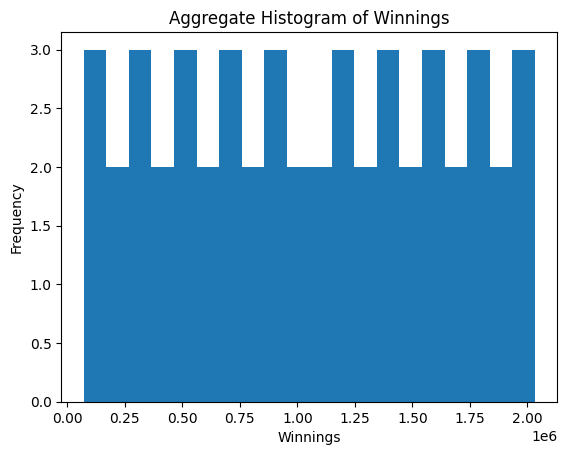

Aggregate Statistics:
Average winnings per round: 21040.0
Standard deviation of winnings: 577234.7875864725
Probability of net winning after 50 rounds: 1.0
Probability of net losing after 50 rounds: 0.0
CardCounterPlayer's total winnings: 0


In [237]:
game = Game()
game.play()

8. Create a loop that runs 100 games of 50 rounds, as setup in previous question, and store the strategy player's chips at the end of the game (aka "winnings") in a list. Histogram the winnings. What is the average winnings per round? What is the standard deviation. What is the probabilty of net winning or lossing after 50 rounds?



Welcome to Blackjack!



Choose mode (auto/regular):  auto
Enter number of games:  100
Enter number of rounds:  50
Enter initial amount of chips per player:  10000


Simulation running...
Player 2 wins 10000 chips.
Player 3 wins 10000 chips.
Player 4 wins 10000 chips.
Player 5 wins 10000 chips.
Player 2 wins 10000 chips.
Player 3 wins 10000 chips.
Player 4 wins 10000 chips.
Player 5 wins 10000 chips.
Player 2 wins 10000 chips.
Player 3 wins 10000 chips.
Player 4 wins 10000 chips.
Player 5 wins 10000 chips.
Player 2 wins 10000 chips.
Player 3 wins 10000 chips.
Player 4 wins 10000 chips.
Player 5 wins 10000 chips.
Player 2 wins 10000 chips.
Player 3 wins 10000 chips.
Player 4 wins 10000 chips.
Player 5 wins 10000 chips.
Player 2 wins 10000 chips.
Player 3 wins 10000 chips.
Player 4 wins 10000 chips.
Player 5 wins 10000 chips.
Player 2 wins 10000 chips.
Player 3 wins 10000 chips.
Player 4 wins 10000 chips.
Player 5 wins 10000 chips.
Player 2 wins 10000 chips.
Player 3 wins 10000 chips.
Player 4 wins 10000 chips.
Player 5 wins 10000 chips.
Player 2 wins 10000 chips.
Player 3 wins 10000 chips.
Player 4 wins 10000 chips.
Player 5 wins 10000 chips.
Player

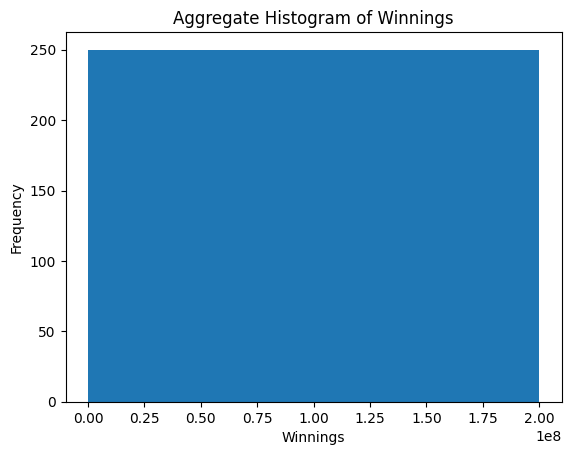

Aggregate Statistics:
Average winnings per round: 20004.0
Standard deviation of winnings: 57735025.76426203
Probability of net winning after 50 rounds: 1.0
Probability of net losing after 50 rounds: 0.0
CardCounterPlayer's total winnings: 0


In [240]:
game = Game()
game.play()

9. Repeat previous questions scanning the value of the threshold. Try at least 5 different threshold values. Can you find an optimal value?


Welcome to Blackjack!



Choose mode (auto/regular):  auto
Enter number of games:  20
Enter number of rounds:  10
Enter initial amount of chips per player:  5000


Simulation running...
Player 2 loses 10000 chips.
Player 3 loses 10000 chips.
Player 4 loses 10000 chips.
Player 5 loses 10000 chips.
Player 2 wins 10000 chips.
Player 3 wins 10000 chips.
Player 4 wins 10000 chips.
Player 5 wins 10000 chips.
Player 2 wins 10000 chips.
Player 3 wins 10000 chips.
Player 4 wins 10000 chips.
Player 5 wins 10000 chips.
Player 2 wins 10000 chips.
Player 3 wins 10000 chips.
Player 4 wins 10000 chips.
Player 5 wins 10000 chips.
Player 2 wins 10000 chips.
Player 3 wins 10000 chips.
Player 4 wins 10000 chips.
Player 5 wins 10000 chips.
Player 2 wins 10000 chips.
Player 3 wins 10000 chips.
Player 4 wins 10000 chips.
Player 5 wins 10000 chips.
Player 2 wins 10000 chips.
Player 3 wins 10000 chips.
Player 4 wins 10000 chips.
Player 5 wins 10000 chips.
Player 2 wins 10000 chips.
Player 3 wins 10000 chips.
Player 4 wins 10000 chips.
Player 5 wins 10000 chips.
Player 2 wins 10000 chips.
Player 3 wins 10000 chips.
Player 4 wins 10000 chips.
Player 5 wins 10000 chips.
Pl

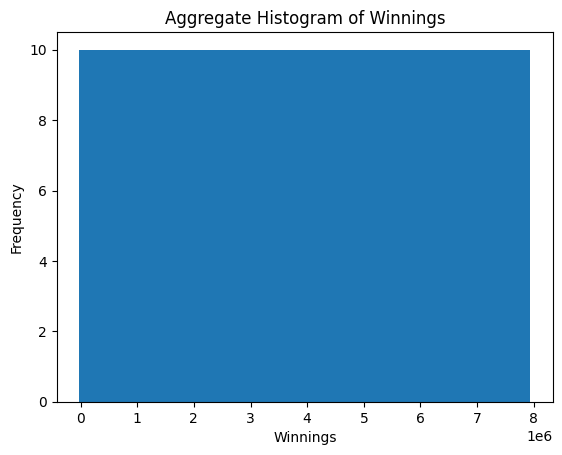

Aggregate Statistics:
Average winnings per round: 19800.0
Standard deviation of winnings: 2309372.209064619
Probability of net winning after 10 rounds: 0.995
Probability of net losing after 10 rounds: 0.005
CardCounterPlayer's total winnings: 0


In [243]:
# Threshold values -2 hit 0 stay
game = Game()
game.play()


Welcome to Blackjack!



Choose mode (auto/regular):  auto
Enter number of games:  20
Enter number of rounds:  10
Enter initial amount of chips per player:  5000


Simulation running...
Player 2 ties with the dealer.
Player 3 loses 10000 chips.
Player 4 loses 10000 chips.
Player 5 loses 10000 chips.
Player 2 wins 10000 chips.
Player 3 wins 10000 chips.
Player 4 wins 10000 chips.
Player 5 wins 10000 chips.
Player 2 wins 10000 chips.
Player 3 wins 10000 chips.
Player 4 wins 10000 chips.
Player 5 wins 10000 chips.
Player 2 wins 10000 chips.
Player 3 wins 10000 chips.
Player 4 wins 10000 chips.
Player 5 wins 10000 chips.
Player 2 wins 10000 chips.
Player 3 wins 10000 chips.
Player 4 wins 10000 chips.
Player 5 wins 10000 chips.
Player 2 wins 10000 chips.
Player 3 wins 10000 chips.
Player 4 wins 10000 chips.
Player 5 wins 10000 chips.
Player 2 wins 10000 chips.
Player 3 wins 10000 chips.
Player 4 wins 10000 chips.
Player 5 wins 10000 chips.
Player 2 wins 10000 chips.
Player 3 wins 10000 chips.
Player 4 wins 10000 chips.
Player 5 wins 10000 chips.
Player 2 wins 10000 chips.
Player 3 wins 10000 chips.
Player 4 wins 10000 chips.
Player 5 wins 10000 chips.

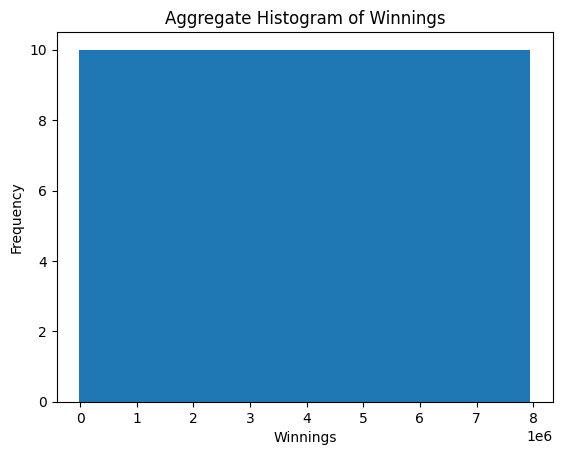

Aggregate Statistics:
Average winnings per round: 19850.0
Standard deviation of winnings: 2309372.209064619
Probability of net winning after 10 rounds: 0.995
Probability of net losing after 10 rounds: 0.005
CardCounterPlayer's total winnings: 0


In [247]:
# Threshold -2 hit -1 stay
game = Game()
game.play()


Welcome to Blackjack!



Choose mode (auto/regular):  auto
Enter number of games:  20
Enter number of rounds:  10
Enter initial amount of chips per player:  5000


Simulation running...
Player 2 wins 10000 chips.
Player 3 wins 10000 chips.
Player 4 wins 10000 chips.
Player 5 wins 10000 chips.
Player 2 wins 10000 chips.
Player 3 wins 10000 chips.
Player 4 wins 10000 chips.
Player 5 wins 10000 chips.
Player 2 wins 10000 chips.
Player 3 wins 10000 chips.
Player 4 wins 10000 chips.
Player 5 wins 10000 chips.
Player 2 wins 10000 chips.
Player 3 wins 10000 chips.
Player 4 wins 10000 chips.
Player 5 wins 10000 chips.
Player 2 wins 10000 chips.
Player 3 wins 10000 chips.
Player 4 wins 10000 chips.
Player 5 wins 10000 chips.
Player 2 wins 10000 chips.
Player 3 wins 10000 chips.
Player 4 wins 10000 chips.
Player 5 wins 10000 chips.
Player 2 wins 10000 chips.
Player 3 wins 10000 chips.
Player 4 wins 10000 chips.
Player 5 wins 10000 chips.
Player 2 wins 10000 chips.
Player 3 wins 10000 chips.
Player 4 wins 10000 chips.
Player 5 wins 10000 chips.
Player 2 wins 10000 chips.
Player 3 wins 10000 chips.
Player 4 wins 10000 chips.
Player 5 wins 10000 chips.
Player

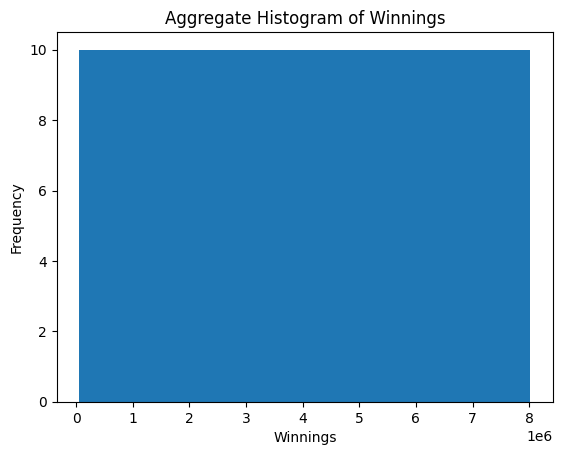

Aggregate Statistics:
Average winnings per round: 20200.0
Standard deviation of winnings: 2309372.209064619
Probability of net winning after 10 rounds: 1.0
Probability of net losing after 10 rounds: 0.0
CardCounterPlayer's total winnings: 0


In [249]:
# Threshold -2 hit 2 stay
game = Game()
game.play()


Welcome to Blackjack!



Choose mode (auto/regular):  auto
Enter number of games:  20
Enter number of rounds:  10
Enter initial amount of chips per player:  5000


Simulation running...
Player 2 wins 10000 chips.
Player 3 wins 10000 chips.
Player 4 wins 10000 chips.
Player 5 wins 10000 chips.
Player 2 wins 10000 chips.
Player 3 wins 10000 chips.
Player 4 wins 10000 chips.
Player 5 wins 10000 chips.
Player 2 wins 10000 chips.
Player 3 wins 10000 chips.
Player 4 wins 10000 chips.
Player 5 wins 10000 chips.
Player 2 wins 10000 chips.
Player 3 wins 10000 chips.
Player 4 wins 10000 chips.
Player 5 wins 10000 chips.
Player 2 wins 10000 chips.
Player 3 wins 10000 chips.
Player 4 wins 10000 chips.
Player 5 wins 10000 chips.
Player 2 wins 10000 chips.
Player 3 wins 10000 chips.
Player 4 wins 10000 chips.
Player 5 wins 10000 chips.
Player 2 wins 10000 chips.
Player 3 wins 10000 chips.
Player 4 wins 10000 chips.
Player 5 wins 10000 chips.
Player 2 wins 10000 chips.
Player 3 wins 10000 chips.
Player 4 wins 10000 chips.
Player 5 wins 10000 chips.
Player 2 wins 10000 chips.
Player 3 wins 10000 chips.
Player 4 wins 10000 chips.
Player 5 wins 10000 chips.
Player

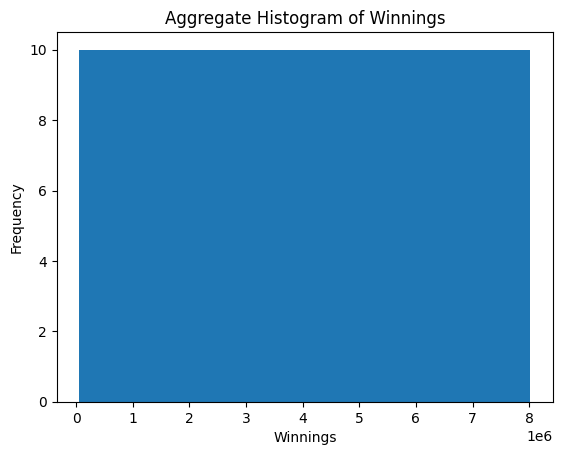

Aggregate Statistics:
Average winnings per round: 20200.0
Standard deviation of winnings: 2309372.209064619
Probability of net winning after 10 rounds: 1.0
Probability of net losing after 10 rounds: 0.0
CardCounterPlayer's total winnings: 0


In [251]:
# Threshold -2 hit 1 stay
game = Game()
game.play()


Welcome to Blackjack!



Choose mode (auto/regular):  auto
Enter number of games:  20
Enter number of rounds:  10
Enter initial amount of chips per player:  5000


Simulation running...
Player 2 wins 10000 chips.
Player 3 wins 10000 chips.
Player 4 wins 10000 chips.
Player 5 wins 10000 chips.
Player 2 wins 10000 chips.
Player 3 wins 10000 chips.
Player 4 wins 10000 chips.
Player 5 wins 10000 chips.
Player 2 wins 10000 chips.
Player 3 wins 10000 chips.
Player 4 wins 10000 chips.
Player 5 wins 10000 chips.
Player 2 wins 10000 chips.
Player 3 wins 10000 chips.
Player 4 wins 10000 chips.
Player 5 wins 10000 chips.
Player 2 wins 10000 chips.
Player 3 wins 10000 chips.
Player 4 wins 10000 chips.
Player 5 wins 10000 chips.
Player 2 wins 10000 chips.
Player 3 wins 10000 chips.
Player 4 wins 10000 chips.
Player 5 wins 10000 chips.
Player 2 wins 10000 chips.
Player 3 wins 10000 chips.
Player 4 wins 10000 chips.
Player 5 wins 10000 chips.
Player 2 wins 10000 chips.
Player 3 wins 10000 chips.
Player 4 wins 10000 chips.
Player 5 wins 10000 chips.
Player 2 wins 10000 chips.
Player 3 wins 10000 chips.
Player 4 wins 10000 chips.
Player 5 wins 10000 chips.
Player

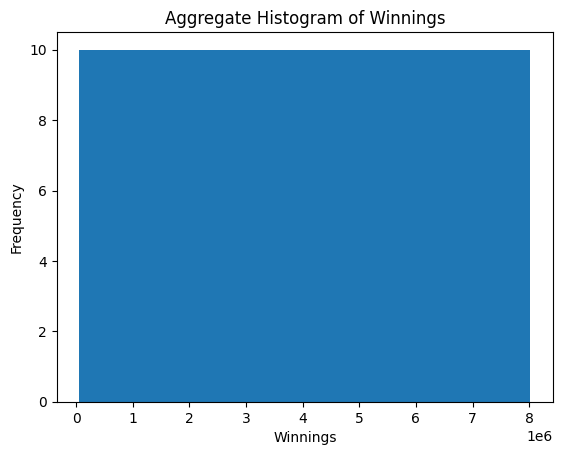

Aggregate Statistics:
Average winnings per round: 20200.0
Standard deviation of winnings: 2309372.209064619
Probability of net winning after 10 rounds: 1.0
Probability of net losing after 10 rounds: 0.0
CardCounterPlayer's total winnings: 0


In [253]:
# Threshold -2 hit -2 stay
game = Game()
game.play()

10. Create a new strategy based on web searches or your own ideas. Demonstrate that the new strategy will result in increased or decreased winnings. 


Welcome to Blackjack!



Choose mode (auto/regular):  auto
Enter number of games:  100
Enter number of rounds:  50
Enter initial amount of chips per player:  50000


Simulation running...



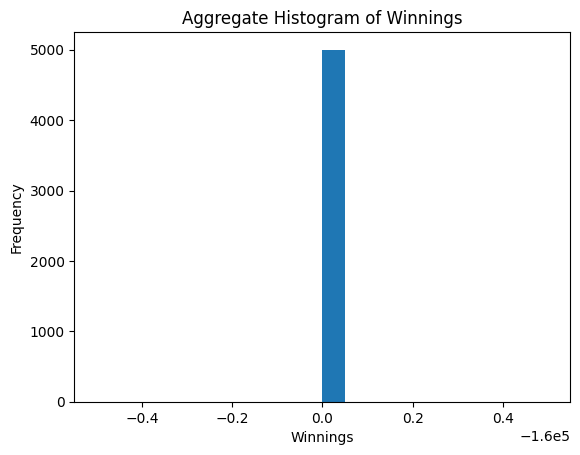

Aggregate Statistics:
Average winnings per round: -32.0
Standard deviation of winnings: 0.0
Probability of net winning after 50 rounds: 0.0
Probability of net losing after 50 rounds: 1.0
CardCounterPlayer's total winnings: 0


In [287]:
# I tried implementing a CardCounterPlayer2 class but my logic looks off. 
game = Game()
game.play()


Welcome to Blackjack!



Choose mode (auto/regular):  auto
Enter number of games:  100
Enter number of rounds:  20
Enter initial amount of chips per player:  50000


Simulation running...



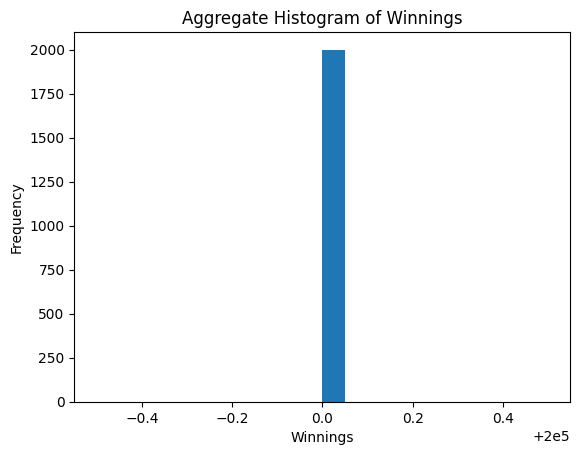

Aggregate Statistics:
Average winnings per round: 100.0
Standard deviation of winnings: 0.0
Probability of net winning after 20 rounds: 1.0
Probability of net losing after 20 rounds: 0.0
CardCounterPlayer's total winnings: 0


In [304]:
game = Game()
game.play()